<a href="https://colab.research.google.com/github/Abhisekh97/Sentiment-Analysis/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-fine-food-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240724%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240724T040658Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3519ba469a8801b7835d7f63b4bff63e373e5ad458ae186281c742561e4faacc854d4e7a86fb90b4179eb0a3324caabfbce4eb64c8fbacde0f3956d52efd0f3797124d817c9b8b87f12ef8c543d717e019a51c6d184de2b43c41896b8dd1c5be2f74f06381cf3aad4ff87a82093a572455137f1adcfaf50cce65c8b483b9ffe9224336d15a75c218121e14f2ced5846e97a2ade707d65647fa35559f1c8e539c292f2bf33c69020c80f8dce9a0e0b3a6f7e145dad62b73532b4fca71da7a970ea9e16016923418107e6e6091aa50d127aab7e605720dd422c04b89dcb4036c76392879148eb98b0449fa9336ea00d981287789f7afb0f9bc837e2562fb61c5a2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 253873708 bytes downloaded
Downloaded and uncompressed: amazon-fine-food-reviews
Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
plt.style.use('ggplot')
nltk.download('stopwords')
print(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df = df[['Text', 'Score']]
df.shape
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [10]:
df = df.sample(n=50000)

## Quick EDA

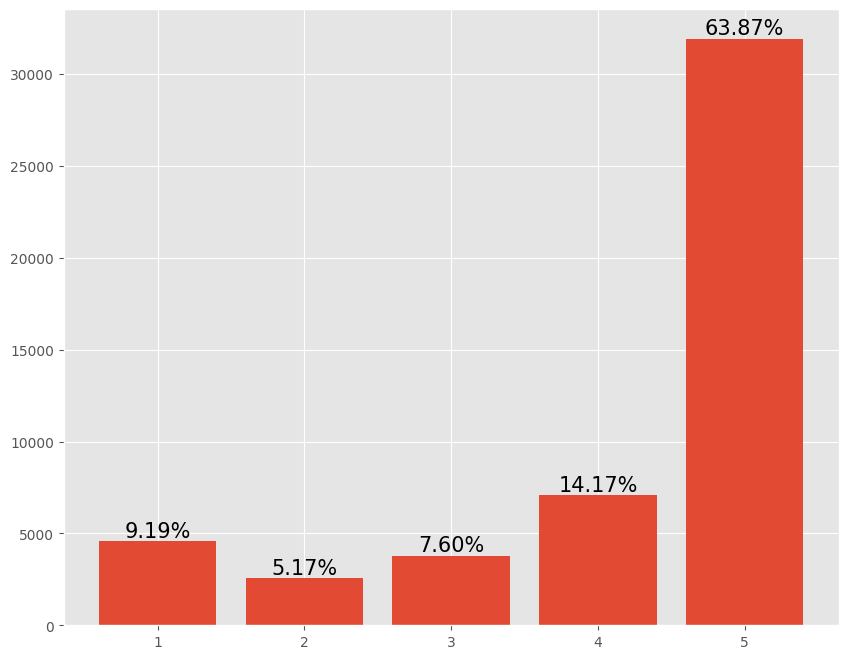

In [11]:
counts = df['Score'].value_counts().sort_index()
plt.figure(figsize=(10, 8))
p1 = plt.bar(np.arange(1,len(counts)+1), counts)

for rect1 in p1:
    height = rect1.get_height()
    value = height/counts.sum()
    plt.annotate( "{:.2f}%".format(value*100),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)

plt.show()

In [12]:
df = df.loc[df['Score']!=3]
df = df.loc[df['Score']!=4]

In [13]:
def category(score):
    return 0 if score==1 or score==2 else 1

In [14]:
df['Sentiment']= df['Score'].apply(category)

In [15]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [16]:

def text_preprocessing(text):
    lower_casing = text.lower()
    tokens = word_tokenize(lower_casing)
    print(tokens)
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and token not in string.punctuation]
    return " ".join(tokens)

In [17]:
df.head()

,Text,Score,Sentiment
464389,Good tasting coffee that works with my Senseo ...,5,1
369893,"My daughter is very picky, but she like this c...",5,1
334285,Barbara's Multigrain Wheat Free Fig Bar is the...,5,1
405618,Perfect drink for beginning morning or before ...,5,1
459531,This is an excellent spice blend. I've used it...,5,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2)

vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)



In [19]:
model = LogisticRegression()

model.fit(X_train_vect, y_train)

LogisticRegression()

In [20]:
y_pred = model.predict(X_test_vect)

In [21]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
score = accuracy_score(y_test, y_pred)
score

0.918200408997955

In [23]:
confusion_metrix = confusion_matrix(y_test, y_pred)
confusion_metrix

array([[ 900,  539],
       [ 101, 6284]])

In [24]:
import pickle

with open('logistic_regression_model.pkl','wb') as f:
    pickle.dump(model,f)